In [115]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Direction reconstruction

**Author(s):**
 - Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Description:**

This notebook contains plots and benchmarks proposals from the _protopipe_ pipeline related to shower reconstruction.  
This was mainly triggered by the step-by-step comparison against _CTA-MARS_, but it can be extended to other pipelines as well.  
**NOTE** Let's try to follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding those benchmarks or proposing new ones.  

**Requirements:**

To run this notebook you will need a DL1 file generated using _protopipe.scripts.data_training.py_ .  
Reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines).

The data format required to run the notebook is the current one used by _protopipe_ . Soon it will be the same as in _ctapipe_ . 

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
Though I will soon start a cross-validation with [ctaplot](https://github.com/cta-observatory/ctaplot)), so if you want to add something and it's already there, please import those functions instead of creating new ones.
The execution of this notebook is not currently automatic due to lack of proper test data, it must be done locally by the user - preferably _before_ pushing a pull-request.

**TODO:**
* ...

## Table of contents
   - [Angular resolution vs true energy](#Angular-resolution)
   - [Reconstruction efficiency vs true energy](#Reconstruction-efficiency)
   - [Distribution of true core positions for reconstructed events](#Distribution-of-true-core-positions-for-reconstructed-events)
   - [Shower maximum height reconstruction](#Shower-maximum-height-reconstruction)

## Imports

In [116]:
import os
from pathlib import Path

import tables
import pandas
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [117]:
def get_camera_names(infile = None):
    """Read the names of the cameras.
    
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    
    Returns
    =======
    camera_names : list(str)
        Table names as a list.
    """
    if infile is None:
        print("ERROR: no input file specified")
    h5file = tables.open_file(infile, mode='r')
    group = h5file.get_node("/")
    camera_names = [x.name for x in group._f_list_nodes()]
    h5file.close()
    return camera_names

In [118]:
def load_reset_infile_protopipe(infile = None, camera_names=None):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type.
     
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    
    Returns
    =======
    dataFrames : dict(pandas.DataFrame)
        Dictionary of tables per camera.
    """
    if infile is None:
        print("ERROR: no input file specified")
    if camera_names is None:
        print("ERROR: no cameras specified")
    # load DL1 images
    dataFrames = {camera : pandas.read_hdf(f"{indir}/{fileName}", f"/{camera}") for camera in camera_names}
    return dataFrames

In [119]:
def add_stats(x, ax):
    """Add a textbox containing statistical information."""
    mu = x.mean()
    median = np.median(x)
    sigma = x.std()
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.70, 0.85, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=10,
            horizontalalignment='left',
            verticalalignment='center', 
            bbox=props)

## Input data
[back to top](#Table-of-contents)

### Protopipe
[back to top](#Table-of-contents)

In [120]:
config = "test" # suffix for all plots

In [121]:
# Please, make sure these variables are empty before pushing any modification
indir = ""
fileName = ""

infile = os.path.join(indir,fileName)

In [122]:
cameras = get_camera_names(infile)

In [123]:
data = load_reset_infile_protopipe(infile = infile, camera_names=cameras)

In [124]:
# select only successfully reconstructed showers
reconstructed_showers = {}
for camera in cameras:
    reconstructed_showers[camera] = data[camera][(data[camera]["is_valid"]==True)]

### CTA-MARS

In [125]:
# TODO

## Plots and benchmarks
[back to top](#Table-of-contents)

In [126]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots_direction_reconstruction").mkdir(parents=True, exist_ok=True)

**Note**  
In ctapipe/protopipe we are not yet applying the Direction LUT, so that is for sure something that plays a difference here.

### Angular resolution
[back to top](#Table-of-contents)

**Note**  
This benchmark uses all events with >=2 valid images, and requiring LST-subarray stereo trigger, i.e. either 0 or >=2 triggered LSTs - since LST-subarray hardware trigger was not required in the simulation

In [127]:
# define an energy binning in TeV
log_lower = -2
log_upper = 2.5
bins_per_decade = 5

true_energy_bin_edges = np.arange(log_lower, log_upper, 1 / bins_per_decade)
true_energy_bin_centers = 0.5 * (true_energy_bin_edges[:-1] + true_energy_bin_edges[1:])

In [128]:
reco_showers_stereo_LST = {}
for i, camera in enumerate(cameras):
    # for each camera select only images corresponing to events seen by either None or at least 2 LSTs (LST stereo trigger condition)
    reco_showers_stereo_LST[camera] = reconstructed_showers[camera][(reconstructed_showers[camera]["N_LST"] == 0) | (reconstructed_showers[camera]["N_LST"] >= 2)]
    # then merge the tables
    if i==0:
        all_reco_showers_stereo_LST = reco_showers_stereo_LST[camera]
    else:
        all_reco_showers_stereo_LST = all_reco_showers_stereo_LST.append(reco_showers_stereo_LST[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_all_reco_showers_stereo_LST = all_reco_showers_stereo_LST.drop_duplicates(subset=['event_id'])

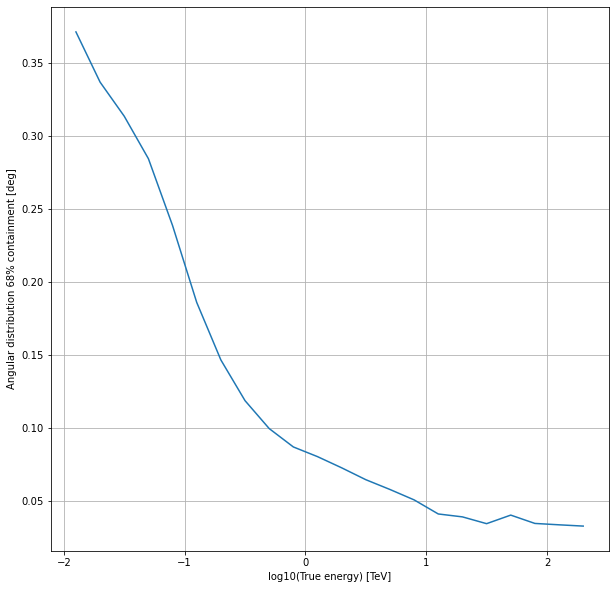

In [129]:
fig = plt.figure(figsize=(10, 10), tight_layout=False)
plt.xlabel("log10(True energy) [TeV]")
plt.ylabel("Angular distribution 68% containment [deg]")

theta = {}
ang_res = np.zeros(len(true_log10energy_centers))
    
true_energy = np.log10(unique_all_reco_showers_stereo_LST["true_energy"])
offset = unique_all_reco_showers_stereo_LST["offset"]

for i in range(len(true_log10energy_centers)):

    mask = (true_energy > true_log10energy_bins[i]) & (true_energy <= true_log10energy_bins[i + 1])
    selected_offsets = np.sort(offset[mask])
    ang_res[i] = np.percentile(selected_offsets, 68.0)

plt.plot(true_log10energy_centers, ang_res, '-')

plt.grid(which="both")
plt.show()

### Reconstruction efficiency
[back to top](#Table-of-contents)

**Note**  
This benchmark uses all events with >=2 valid images, and requiring LST-subarray stereo trigger, i.e. either 0 or >=2 triggered LSTs - since LST-subarray hardware trigger was not required in the simulation

In [130]:
all_showers_stereo_LST = {}
for i, camera in enumerate(cameras):
    # for each camera select only images corresponing to events seen by either None or at least 2 LSTs (LST stereo trigger condition)
    all_showers_stereo_LST[camera] = data[camera][(data[camera]["N_LST"] == 0) | (data[camera]["N_LST"] >= 2)]
    # then merge the tables
    if i==0:
        allcameras_allshowers_stereo_LST = all_showers_stereo_LST[camera]
    else:
        allcameras_allshowers_stereo_LST = allcameras_allshowers_stereo_LST.append(all_showers_stereo_LST[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_allcameras_allshowers_stereo_LST = allcameras_allshowers_stereo_LST.drop_duplicates(subset=['event_id'])

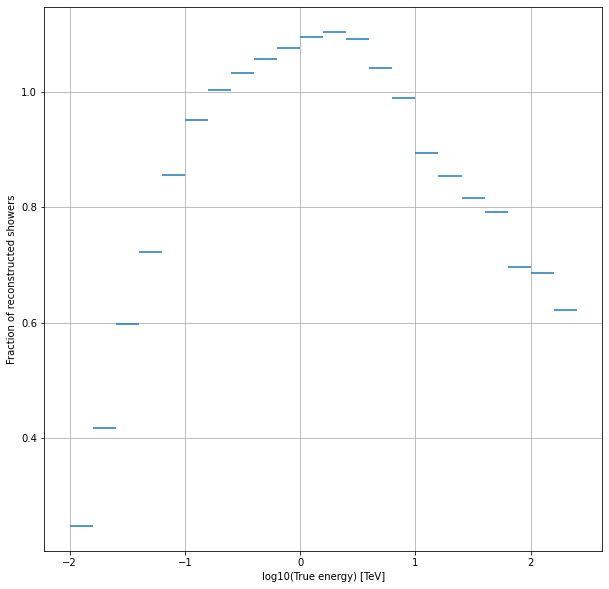

In [131]:
fig = plt.figure(figsize=(10, 10), tight_layout=False)

plt.xlabel("log10(True energy) [TeV]")
plt.ylabel("Fraction of reconstructed showers")
    
true_energy_all = np.log10(unique_allcameras_allshowers_stereo_LST["true_energy"])
true_energy_reco = np.log10(unique_all_reco_showers_stereo_LST["true_energy"])
eff = np.zeros(len(true_log10energy_centers))

for i in range(len(true_log10energy_bins)-1):

    mask_all = (true_energy_all > true_log10energy_bins[i]) & (true_energy_all <= true_log10energy_bins[i + 1])
    mask_reco = (true_energy_reco > true_log10energy_bins[i]) & (true_energy_reco <= true_log10energy_bins[i + 1])
    all_showers_per_energy_bin = unique_allcameras_allshowers_stereo_LST[mask_all]
    reco_showers_per_energy_bin = unique_all_reco_showers_stereo_LST[mask_reco]
    eff[i] = len(reco_showers_per_energy_bin)/len(all_showers_per_energy_bin)

plt.errorbar(true_log10energy_centers, eff, xerr=np.diff(true_log10energy_bins)/2, yerr = None, ls='none')

plt.grid(which="both")
plt.show()

### Distribution of true core positions for reconstructed events
[back to top](#Table-of-contents)

**Note**  
This benchmark uses all events with >=2 valid images, and requiring LST-subarray stereo trigger, i.e. either 0 or >=2 triggered LSTs - since LST-subarray hardware trigger was not required in the simulation

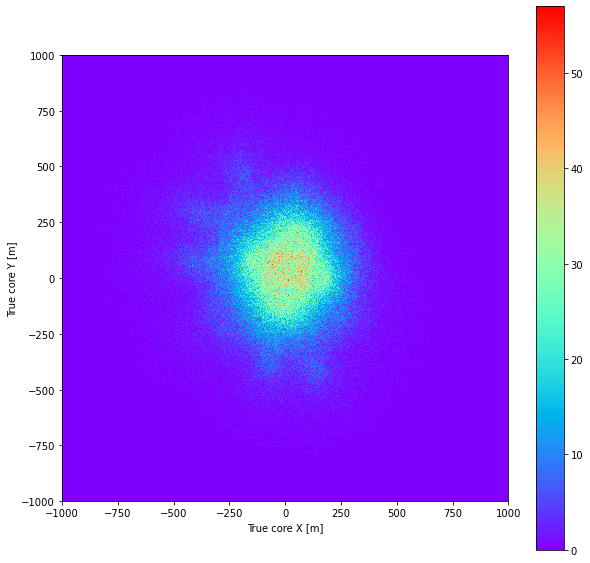

In [132]:
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal')

nbins = 450

core_distribution = plt.hist2d(x = unique_all_reco_showers_stereo_LST["mc_core_x"],
           y = unique_all_reco_showers_stereo_LST["mc_core_y"],
           bins=[nbins, nbins],
           range=[[-1.e3, 1.e3], [-1.e3, 1.e3]],
           cmap=plt.cm.rainbow,
           )

plt.colorbar(core_distribution[3], ax=plt.gca())

plt.xlabel("True core X [m]")
plt.ylabel("True core Y [m]")

plt.show()

### Shower core reconstruction
[back to top](#Table-of-contents)

All showers reconstructed by any 2 telescopes

In [133]:
reco_showers_stereo = {}
for i, camera in enumerate(cameras):
    # for each camera table select only rows corresponing to events seen by any >=2 telescopes
    reco_showers_stereo[camera] = reconstructed_showers[camera][reconstructed_showers[camera]["n_tel_reco"] >= 2]
    # then merge the tables
    if i==0:
        allcameras_reco_showers_stereo = reco_showers_stereo[camera]
    else:
        allcameras_reco_showers_stereo = allcameras_reco_showers_stereo.append(reco_showers_stereo[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_allcameras_reco_showers_stereo = allcameras_reco_showers_stereo.drop_duplicates(subset=['event_id'])

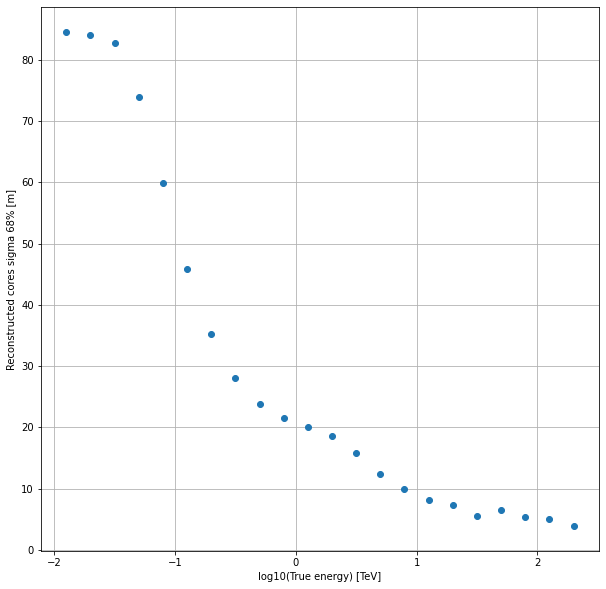

In [139]:
core_res = np.zeros(len(true_log10energy_centers))

fig = plt.figure(figsize=(10, 10))
plt.xlabel("log10(True energy) [TeV]")
plt.ylabel("Reconstructed cores sigma 68% [m]")

true_energy = np.log10(unique_allcameras_reco_showers_stereo["true_energy"])

true_core_x = unique_allcameras_reco_showers_stereo["mc_core_x"]
true_core_y = unique_allcameras_reco_showers_stereo["mc_core_y"]
reco_core_x = unique_allcameras_reco_showers_stereo["reco_core_x"]
reco_core_y = unique_allcameras_reco_showers_stereo["reco_core_y"]

core_distances = np.sqrt((true_core_x - reco_core_x)**2 + (true_core_y - reco_core_y)**2)

for i in range(len(true_log10energy_centers)):

    mask = (true_energy > true_log10energy_bins[i]) & (true_energy <= true_log10energy_bins[i + 1])
    selected_core_distances = np.sort(core_distances[mask])
    core_res[i] = np.percentile(selected_core_distances, 68.0)

plt.plot(true_log10energy_centers, core_res, 'o')

plt.grid(which="both")
plt.show()

### Shower maximum height reconstruction
[back to top](#Table-of-contents)

All showers reconstructed by at least 2 telescopes.

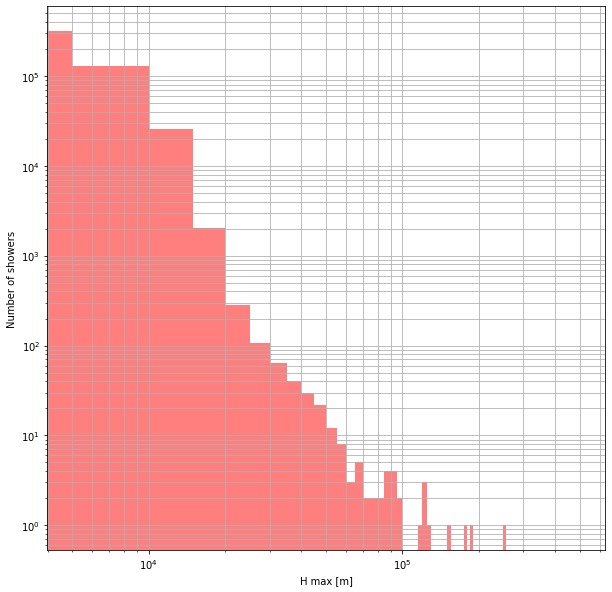

In [135]:
plt.figure(figsize=(10,10))
plt.hist(unique_allcameras_reco_showers_stereo["h_max"], bins=100, range=[0, 0.5e6], alpha=0.5, color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("H max [m]")
plt.ylabel("Number of showers")
plt.grid(which="both")
plt.show()